In [1]:
import pyodbc
import pandas as pd
import numpy as np

#used to clean
import string
import re
import numpy as np
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#used to vectorize
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix#, find

#used to pairwise compare
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

#used to visualize
import matplotlib.pyplot as plt
import seaborn as sns;

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cory.beyer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=***;"
                      "Database=***;"
                      "uid=***;pwd=***")

sql =  """WITH offense as
             (SELECT lwmainid, ucr_code
              FROM lwchrg
              WHERE chrgcnt =1)

          SELECT 
          inci_id, 
          date_rept, 
          supplement

         FROM lwmain
            INNER JOIN offense on offense.lwmainid = lwmain.lwmainid 

         WHERE 
         date_rept >= DATEADD(month,-7,GETDATE()) and 
         not supplement is null and 
         agency ='***' and
         not ucr_code = '90D'"""

df = pd.read_sql(sql,cnxn,parse_dates= ['calltime'])
df.set_index('inci_id');

In [3]:
def clean(doc):
    copwords = ['introduction','approximately','call','arrive','scene','and','arrived','spoke','interview','informed',
                'observed','regarding','contact','report','of','patrol', 'officer','i','to', 'that','on','was',
                'assist','reporting','affidavit','duty','assigned','dispatched', 'summary', 'reference',
                'while','disposition', 'evidence','victim','reportee','at','city','limits','occurred','as','responded',
                'advised','lobby','which','location','complaint','incident','resulted','result','being','located',
                'disposition','police','department']
    stop = set(stopwords.words('english')).union(copwords)
    lemma = WordNetLemmatizer()
    text = re.sub(r'\[[0-9]*\]', ' ',doc)
    text = re.sub(r'\s+', ' ',text)
    text = text.lower()
    text = re.sub(r'[@#\$%&\*\(\)\<\>\\/\?\'\":;\]\,\.\[-]', ' ',text)
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+', ' ', text)
    text = " ".join([i for i in text.lower().split() if i not in stop])
    text = " ".join(lemma.lemmatize(word) for word in text.split())
    processed = re.sub(r"\d+","",text)
    return processed

In [4]:
#apply cleaning
df['cleaned'] = df['supplement'].apply(clean)

In [5]:
#Vectorizing the narratives
count_vector = CountVectorizer()

In [6]:
# Instantiating convertor object
count_vector = CountVectorizer()

# tranforming and making to a sparse matrix for more efficient computations.
document_term_matrix = csr_matrix(count_vector.fit_transform(df.cleaned))

document_term_matrix = document_term_matrix.todense()
document_term_matrix_df = pd.DataFrame(document_term_matrix, columns = count_vector.get_feature_names())

In [7]:
#The vectorized matrix
document_term_matrix 

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [8]:
#the dictionary
#count_vector.get_feature_names()

In [9]:
pairwise_matrix = pd.DataFrame(cosine_similarity(document_term_matrix_df,dense_output=True))
pairwise_matrix = pairwise_matrix.set_index(df.inci_id)
pairwise_matrix.columns = df.inci_id
pairwise_matrix.head()

inci_id,213355,213356,213357,213359,213362,213361,213365,213371,213370,213379,...,220545,220547,220594,220595,220600,220601,220587,220592,220599,220612
inci_id,,,,,,,,,,,,,,,,,,,,,
213355,1.000000,0.094999,0.077185,0.219440,0.070990,0.173412,0.041605,0.226309,0.206801,0.234418,...,0.263094,0.053751,0.046803,0.052839,0.041925,0.279874,0.207905,0.082806,0.039061,0.122890
213356,0.094999,1.000000,0.124319,0.081564,0.072600,0.081902,0.109616,0.035303,0.070633,0.042717,...,0.066367,0.070994,0.096138,0.099015,0.054732,0.044222,0.124805,0.089729,0.069536,0.121538
213357,0.077185,0.124319,1.000000,0.131791,0.062211,0.047653,0.088316,0.044351,0.076186,0.042398,...,0.052308,0.066608,0.057033,0.063879,0.033207,0.051157,0.080422,0.051330,0.052357,0.061286
213359,0.219440,0.081564,0.131791,1.000000,0.183670,0.148967,0.058808,0.161251,0.153703,0.207188,...,0.232480,0.036943,0.104772,0.098272,0.075528,0.180725,0.195981,0.093546,0.065579,0.075688
213362,0.070990,0.072600,0.062211,0.183670,1.000000,0.132473,0.085046,0.084295,0.071227,0.078105,...,0.128282,0.039507,0.049219,0.219061,0.043669,0.073310,0.136919,0.060938,0.039120,0.044445


<AxesSubplot:xlabel='inci_id', ylabel='inci_id'>

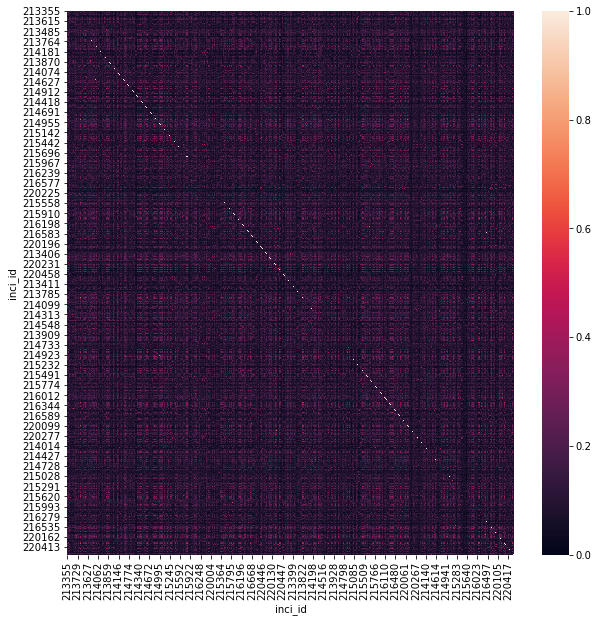

In [10]:
#visualize the matrix above
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(pairwise_matrix)

In [11]:
#only keep similarity scores between .69 and .99
filtered = pairwise_matrix[pairwise_matrix.gt(.69) & pairwise_matrix.lt(.99)]

In [12]:
#searching the matrix and making a new file for the filtered records and their matching report
z=[]
for i,j in enumerate(filtered.values):
    for n in range(len(filtered.columns)):
        z.append([filtered.index[i],filtered.columns[n],j[n]])

df3 = pd.DataFrame(z)
df3.dropna(inplace=True)
df3.columns =['Matching Report 1','Mathcing Report 2','Similarity Score']

In [13]:
df3.head(20)

,Matching Report 1,Mathcing Report 2,Similarity Score
128930,213712,213714,0.765070
133982,213714,213712,0.765070
164321,213771,213773,0.984054
166847,213773,213771,0.984054
346337,213780,213781,0.790730
348863,213781,213780,0.790730
402033,213885,213888,0.811626
407167,213972,214573,0.817171
409221,213972,216487,0.749566
409223,213972,216490,0.749845
